# **ronn**: AI audio effect
*Create your own audio effect / distortion / reverb / delay / filter with random neural networks.*


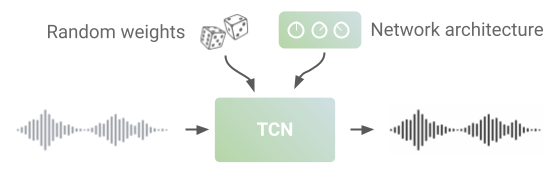

Follow the steps below to construct a random neural network and process your audio through it. Adjust the sliders to control the design of the neural network and hear how it changes the audio. 

- Watch the [demo on YouTube](https://www.youtube.com/watch?v=s1p_CvwDEB8) to hear some sound examples.
- Learn more in the [paper](https://arxiv.org/abs/2010.04237)
- Check out the code on [GitHub](https://github.com/csteinmetz1/ronn)

Notebook created by [Christian Steinmetz](https://twitter.com/csteinmetz1).

# Setup
This grabs the code and installs the dependancies.

In [ ]:
!pip install torchaudio
!git clone https://github.com/csteinmetz1/ronn.git
!pip install ronn/dev

     |████████████████████████████████| 1.9 MB 6.8 MB/s 
Cloning into 'ronn'...
remote: Enumerating objects: 3441, done.
remote: Counting objects: 100% (3441/3441), done.
remote: Compressing objects: 100% (2660/2660), done.
remote: Total 3441 (delta 836), reused 3269 (delta 667), pack-reused 0
Receiving objects: 100% (3441/3441), 15.33 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (836/836), done.
Processing ./ronn/dev
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for ronn: filename=ronn-0.1.0-py3-none-any.whl size=4709 sha256=8bddc788e82eea8baa64cbe083ff3de29ad29c7a40963eb5eb6a064e3239cdd7
  Stored in directory: /tmp/pip-ep

In [ ]:
import sys
import torch
import IPython
import torchaudio
import numpy as np
import scipy.signal
from google.colab import files

from ronn.model import ronnModel
from ronn.utils import calculate_receptive_field

In [ ]:
# download audio demos 
!wget https://csteinmetz1.github.io/tcn-audio-effects/audio/mushra/pianoA-0-65-input.mp3
!wget https://csteinmetz1.github.io/sounds/assets/looperman-a-0107696-0000348-holly-time.mp3
!wget https://csteinmetz1.github.io/sounds/assets/short_riff.wav
!wget https://csteinmetz1.github.io/sounds/assets/looperman-l-4108535-0263258-hip-hop-beat-without-bass.wav

--2021-08-24 18:22:49--  https://csteinmetz1.github.io/tcn-audio-effects/audio/mushra/pianoA-0-65-input.mp3
Resolving csteinmetz1.github.io (csteinmetz1.github.io)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to csteinmetz1.github.io (csteinmetz1.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214069 (209K) [audio/mp3]
Saving to: ‘pianoA-0-65-input.mp3’

pianoA-0-65-input.m 100%[===================>] 209.05K  --.-KB/s    in 0.02s   

2021-08-24 18:22:49 (12.2 MB/s) - ‘pianoA-0-65-input.mp3’ saved [214069/214069]

--2021-08-24 18:22:49--  https://csteinmetz1.github.io/sounds/assets/looperman-a-0107696-0000348-holly-time.mp3
Resolving csteinmetz1.github.io (csteinmetz1.github.io)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to csteinmetz1.github.io (csteinmetz1.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392907 (384K) [audio/mp3]
Sa

In [ ]:
def run(x, sample_rate, params, max_duration=30, input_gain_dB=0.0):
  """ Build a random network given parameters, and process audio. 

  Args:
    x (Tensor): Input audio tensor.
    sample_rate (int): Sample rate of the audio tensor.
    params (dict): Parameter dictionary
    max_duration (float): Maximum number of seconds to process.
    input_gain_dB (float): Apply some gain to the input signal.

  Returns:
    out (Tensor): Output audio.

  """

  c, s = x.size()

  # check if the receptive field is too big first
  rf = calculate_receptive_field(
    params["kernel_size"],
    params["n_layers"],
    1,
    params["dilation_growth"] ** np.arange(params["n_layers"]),
  )

  print("Dilations: ", params["dilation_growth"] ** np.arange(params["n_layers"]))

  if rf > 500000: 
    raise RuntimeError("Warning! Maximum receptive field exceeded. Try reducing n_layers or dilation_growth.")

  # max duration in samples
  max_duration_samples = max_duration * sample_rate

  if x.shape[-1] > max_duration_samples:
    print(f"Warning! Input file is larger than max_duration. Truncating input to {max_duration:0.1f} seconds.")
    x = x[...,:max_duration_samples]

  # construct the model with our desired parameters
  processor = ronnModel(**params)
  processor.to("cuda")

  print(f"Receptive field: {rf} samples or {(rf/sample_rate)*1000:0.2f} ms @ {sample_rate/1e3:0.1f} kHz")

  # apply gain
  x_gain = x * 10 ** (input_gain_dB/20.0)

  x_pad = torch.nn.functional.pad(x_gain, (rf-1, rf-1))
  x_pad = x_pad.view(1, c, -1)
  y = None

  x_pad = x_pad.to("cuda")

  # process that audio
  with torch.no_grad():
    out = processor(x_pad)

  # remove DC
  sos = scipy.signal.butter(8, 20.0, fs=sample_rate, output="sos", btype="highpass")
  out = scipy.signal.sosfilt(sos, out.cpu().view(params["n_outputs"],-1).numpy()).astype(np.float32)
  out = torch.tensor(out)

  # normalize
  out /= out.abs().max()

  # change view
  out = out.cpu().view(params["n_outputs"], -1)

  # save to disk
  torchaudio.save("out.wav", out, sample_rate)

  return x, out

# Make some sounds
First we need to get some audio. Select one of the options below.

In [ ]:
#@title ## Use the default audio
#@markdown Jump right in and start with one of the default samples.
audio_sample = "Guitar" #@param ["Vocal", "Guitar", "Drums"]
#@markdown Source: [Vocal](https://www.looperman.com/acapellas/detail/348/time-by-holly-110bpm-jazz-acapella) | [Drums](https://www.looperman.com/loops/detail/263258/hip-hop-beat-without-bass-free-140bpm-hip-hop-drum-loop).

if audio_sample == "Vocal":
  filename = "looperman-a-0107696-0000348-holly-time.mp3"
elif audio_sample == "Guitar":
  filename = "short_riff.wav"
else:
  filename = "looperman-l-4108535-0263258-hip-hop-beat-without-bass.wav"

x, sample_rate = torchaudio.load(filename)
c, s = x.size()
print("Input preview (30 sec)")
IPython.display.display(IPython.display.Audio(data=x[:,:int(sample_rate*30.0)], rate=sample_rate))

In [ ]:
#@title ## Upload
#@markdown Or, select an audio file from your local machine.
uploaded = files.upload()
x, sample_rate = torchaudio.load(list(uploaded.keys())[-1])
c, s = x.size()
print("Input preview (30 sec)")
IPython.display.display(IPython.display.Audio(data=x[:,:int(sample_rate*30.0)], rate=sample_rate))

Use the default parameters or set your own and then run to generate audio. 

The output audio will appear below when it's ready and may take 3-10 seconds.

In [ ]:
#@title ronn parameters { vertical-output: true, form-width: "60%" }
input_gain_dB = 0 #@param {type:"slider", min:-24, max:24, step:1}
n_layers = 4 #@param {type:"slider", min:1, max:6, step:1}
n_channels = 32 #@param {type:"slider", min:1, max:32, step:1}
kernel_size = 21 #@param {type:"slider", min:1, max:128, step:1}
dilation_growth = 20 #@param {type:"slider", min:1, max:20, step:1}
seed = 25 #@param {type:"slider", min:1, max:100, step:1}
init = "xavier_uniform" #@param ["normal", "uniform", "xavier_uniform", "xavier_normal", "kaiming_uniform"]
activation = "ELU" #@param ["ReLU", "LeakyReLU", "Tanh", "Sigmoid", "ELU", "RReLU", "SELU", "GELU", "Softplus", "Softshrink"]
max_duration = 15 #@param {type:"slider", min:1, max:320, step:1}

params = {"n_inputs": c, "n_outputs": 2, "n_layers": n_layers, 
          "n_channels": n_channels, "kernel_size": kernel_size,
          "activation": activation, "dilation_growth": dilation_growth,
          "init": init, "film_dim": 2, "seed": seed}

x_crop, out = run(x, sample_rate, params, max_duration, input_gain_dB)

print("Output")
IPython.display.display(IPython.display.Audio(data=out, rate=sample_rate))


In [ ]:
#@markdown Now you can mix the original signal back in with the output and control the strength of the effect.
strength = 25 #@param {type:"slider", min:0, max:100, step:1}
x_crop_norm = x_crop / x_crop.abs().max()
pad_size = out.shape[-1] - x_crop_norm.shape[-1]
x_crop_norm = torch.nn.functional.pad(x_crop_norm, (0,pad_size))
out_norm = out / out.abs().max()
out_mix = ((1-(strength/100)) * x_crop_norm) + ((strength/100) * out_norm)

print("Mix")
IPython.display.display(IPython.display.Audio(data=out_mix, rate=sample_rate))

In [ ]:
#@title ## Download
#@markdown Save the output to your machine and add it to your DAW.
files.download('out.wav')

# What is ronn?

Throughout audio technology history, engineers, circuit designers, and guitarists have searched tirelessly for novel, extreme, and exciting effects as a result of clipping audio signals. Whether it be vacuum tubes (valves), diodes, transistors, op-amps, microchips, or broken speaker drivers doing the distorting, it seems that we have tried them all. But maybe there is at least one area left relatively under-explored, and thats the realm of neural networks.

Now neural networks, have been a round for a bit. They have actually **already** been used to model distortion and overdrive effects from guitar amplifier and pedals quite a bit. So then you may be asking, "*well how is this any different?*" And the answer is, **ronn** doesn't model **ANY** pre-existing audio circuit, we don't even bother to train anything! Instead we treat the concept of the neural network as a system which can distort a signal, and then we give the user control over that system to explore new effects. Get your hands dirty building neural networks without even touching TensorFlow or PyTorch.

# Tips

Having some trouble getting an interesting sound? Here are some tips to discover some interesting effects based on our experimentation.

First, let's go over some basic intution for each of parameters:
- `input_gain_dB`: This lets you *drive* the network more or less to achieve more distortion. 
- `n_layers`: This controls the number of convolutional layers in the network. Adding more layers increases the number of activations the audio goes through, often increasing the amount of distortion. It also makes the processing take longer.
- `n_channels`: This controls the number of convolutional channels in each layer. Again, increasing the number of channels increases the processing time, but we find that interestingly, more channels often results in a richer effect.
- `kernel_size`: This controls the size of each convolutional kernel. Larger kernels will create a more smooth and reverb-like effect. Very short kernels often sound more like distortion. 
- `dilation_growth`: This may be one of the most important parameters. Increasing the dilation growth enables VERY large receptive field without many parameters, by using sparse kernels. Cranking this up can produce interesting reverb and even granular synthesis-like effects. Watch out though, since this can easily cause the processing to be too much.
- `seed`: This enables reproducability since the models have random weights. If you pick one configuration and you don't get any sound out or the left and right channels are not balanced, try changing the seed and running the cell again. 
- `init`: This sets the sampling method for the random weights. Changing this may result in a model that outputs silence, so the default `xaiver_normal
- `activation`: Choose from a number of common neural network activations. These will all have a clear impact on the sound. Try Tanh, ReLU, or LeakyReLU for super distorted sounds, and try ELU, SELU, or GELU for much smoother sounds.
- `max_duration`: This restricts the length of the audio file that is processed, as a safety precaution. Increase this if you want to process more audio, but be warned it may cause the runtime to crash.
